Image portrait mode converter

this program includes two functions:


basic function: blur the background


enhanced function: change a background and blur

first, run blocks below to install dependencies.

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights
!pip install gradio

  Preparing metadata (setup.py) ... done


In [ ]:
import torch
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")

In [ ]:
import cv2
import supervision as sv
from segment_anything import sam_model_registry, SamPredictor
import base64
import numpy as np
from google.colab import files
import PIL
import gradio as gr

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

HOME = os.getcwd()
print("HOME:", HOME)
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_predictor = SamPredictor(sam)


HOME: /content


Now, please upload the image

In [ ]:
uploaded = files.upload()
IMAGE_NAME = list(uploaded.keys())[0]
IMAGE_PATH = os.path.join(HOME, IMAGE_NAME)

Saving 4.jpg to 4.jpg


Now, please draw box to annotate the part that you dont want to blur (the subject of image).

You can draw multiple boxes, and the boxes can be overlapping each other.

For best performance, please refer to the example in readme file.

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

Computing the mask. You can go back to the last block if you are not satisfied with the result.


(sometimes supervision.MaskAnnotator would produce some strange bugs, so we just directly show the merged mask here).

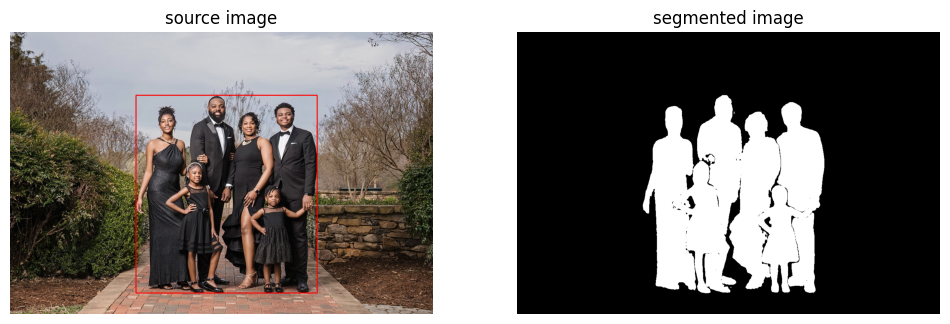

if you are not satisfied with the segmentation result, you can go back to the last part of the code to draw boxes again. 


In [ ]:
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

default_box = {'x':68, 'y':247, 'width':555, 'height': 678, 'label':''}
box = [] if widget.bboxes else [np.array([default_box['x'], default_box['y'],
    default_box['x']+ default_box['width'], default_box['y']+default_box['height']])]

for b in widget.bboxes:
  box.append(np.array([
    b['x'],
    b['y'],
    b['x']+b['width'],
    b['y']+b['height']]))
maskset = []
t = 0.7

mask_predictor.set_image(image_rgb)
for b in box:
    masks, scores, logits = mask_predictor.predict(
        box=b,
        multimask_output=True
    )
    for i in range(len(masks)):
      if scores[i] >= t:
        maskset.append(masks[i])

maskset = [mask.astype(np.uint8) for mask in maskset]
merged_mask = np.zeros_like(maskset[0], dtype=np.uint8)
for mask in maskset:
  merged_mask = cv2.bitwise_or(merged_mask, mask)
temp = merged_mask.copy()
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=np.array([temp, temp])),
    mask=np.array([temp, temp])
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = merged_mask

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

print("if you are not satisfied with the segmentation result, you can go back to the last part of the code to draw boxes again. ")

Function 1: blur the background of the image.


Please enter the blurring strength (the size of Gaussian Blur kernel)


(the function is designed to be tolerant with even numbers,

for example, if you enter strength=4, the actual kernel size is 3.)

In [ ]:
def blur(strength):
  if strength % 2 == 0:
    strength -= 1
  blurred = image_rgb.copy()
  blurred = cv2.GaussianBlur(blurred,(strength,strength),0)
  blurred = np.array(blurred)
  original = np.array(image_rgb.copy())
  for i in range(len(blurred)):
    for j in range(len(blurred[i])):
      if(merged_mask[i][j])>0:
        blurred[i][j] = original[i][j]
  blurred = cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB)
  cv2.imwrite("blurred.jpg", blurred)
  blurred = cv2.cvtColor(blurred, cv2.COLOR_RGB2BGR)
  blurred = PIL.Image.fromarray(blurred)
  return blurred

interface = gr.Interface(
    fn=blur,
    inputs=[
        gr.Slider(minimum=1, maximum=45, step=1, label="blurring strength (1=notblurred), odd numbers only")
    ],
    outputs=gr.Image(type="pil", label="blurred image"),
    title="image portrait mode"
)

interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://29d6ca3584dceba41e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Enhanced portrait mode: you can upload a new image as background.

The subjects will be moved onto the new image, and the background will be blurred.(if you dont want to blur it, just set strength=1.)

In [ ]:
def replace(img, strength):
  if strength % 2 == 0:
    strength -= 1
  img = np.array(img)
  original = np.array(image_rgb.copy())
  img = cv2.resize(img, (image_rgb.shape[1], image_rgb.shape[0]), interpolation=cv2.INTER_LINEAR)
  img = cv2.GaussianBlur(img,(strength,strength),0)
  img = np.array(img)
  for i in range(len(img)):
    for j in range(len(img[i])):
      if(merged_mask[i][j])>0:
        img[i][j] = original[i][j]
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  cv2.imwrite("background_replaced.jpg", img)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = PIL.Image.fromarray(img)
  return img

interface = gr.Interface(
    fn=replace,
    inputs=[
        gr.Image(type="pil", label="upload an alternative background image"),
        gr.Slider(minimum=1, maximum=45, step=1, label="blurring strength (1=not blurred), odd numbers only")
    ],
    outputs=gr.Image(type="pil", label="image with background replaced"),
    title="image background replacement & blurring"
)

interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://26af7618bccf91d67c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
